# Import and settings

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os, gc, re, joblib
import numpy as np
import scipy.sparse as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize as cnorm
import matplotlib.cm as cm
import anndata
import scanpy as sc
import sctk as sk
import bbknn
import phate

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
np.set_printoptions(linewidth=180)
sc.settings.verbosity = 1
expr_cmap = sk.expression_colormap()

In [2]:
state_cmap = ListedColormap(['red', 'black'])

# Load data

In [3]:
rna_ad = sc.read('scRNA_batch1_2.processed.h5ad')

In [4]:
rna_ad

AnnData object with n_obs × n_vars = 38116 × 17590
    obs: 'doublet_bh_pval', 'n_counts', 'sample_id', 'scrublet_score', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'percent_top50', 'GEX_SID', 'ATAC_SID', 'GEX', 'ATAC', 'Sample', 'DOB', 'Gender', 'date', 'age_years', 'state', 'disease', 'site_taken_fine', 'site_taken_broad', 'sorted', 'Nancy_histologic_score', 'slide_look_other', 'whole_tissue_signature', 'scSeq', 'bulkSeq', 'annot_batch1_lr', 'annot_batch1_lr_prob', 'annot_batch2_lr', 'annot_batch2_lr_prob', 'leiden_bk_r0_1', 'leiden_bk_r0_3', 'leiden_bk_r0_5', 'is_doublet', 'leiden_bk_split1', 'leiden_bk_split2', 'leiden_bk_split3', 'annot1', 'leiden_bk_split4', 'annot_gut_lr', 'annot_gut_lr_prob', 'broad_annot1'
    var: 'gene_ids', 'mito', 'ribo', 'hb', 'n_counts', 'n_cells', 'cc', 'highly_variable', 'highly_variable_nbatches', 'hvg_full'
    uns: 'leiden', 'neighbors', 'neighbors_bk', 'pca'
    obsm: 'X_pca', 'X_umap_bk'
    varm: '

In [5]:
rna_ad.obs.annot1.cat.categories

Index(['S3', 'S1', 'VE arterial tip', 'VE capillary', 'VE arterial',
       'VE postcapillary venlue', 'S3x', 'S5', 'S2', 'LE', 'MF1', 'MF2', 'PC',
       'GL', 'S4', 'IM'],
      dtype='object')

In [6]:
rna_ad.obs.annot1.cat.reorder_categories([
    'S1', 'S2', 'S3', 'S3x', 'S4', 'S5', 'MF1', 'MF2', 'PC',
    'LE', 'VE arterial tip', 'VE capillary', 'VE arterial', 'VE postcapillary venlue',
    'GL', 'IM'
], inplace=True)

In [7]:
rna_ad.obs[['GEX_SID', 'ATAC_SID', 'GEX', 'ATAC', 'Sample', 'DOB', 'Gender', 'date', 'age_years', 'state', 'disease', 'site_taken_fine', 'site_taken_broad', 'sorted', 'Nancy_histologic_score', 'slide_look_other', 'whole_tissue_signature']].head()

,GEX_SID,ATAC_SID,GEX,ATAC,Sample,DOB,Gender,date,age_years,state,disease,site_taken_fine,site_taken_broad,sorted,Nancy_histologic_score,slide_look_other,whole_tissue_signature
index,,,,,,,,,,,,,,,,,
AAACCCATCGTGCTCT-R01,R01,A01,GX46,NX02,110544,24/10/1951,M,21/6/2018,66,inflamed,CD,ileo-colon,small intestine,CD45-EPCAM-CD31-THY1+PDPN+,4.0,"ulcers, granulation tissue (swapped?)",high
AAACGAACATGTTACG-R01,R01,A01,GX46,NX02,110544,24/10/1951,M,21/6/2018,66,inflamed,CD,ileo-colon,small intestine,CD45-EPCAM-CD31-THY1+PDPN+,4.0,"ulcers, granulation tissue (swapped?)",high
AAACGAAGTTCCGTTC-R01,R01,A01,GX46,NX02,110544,24/10/1951,M,21/6/2018,66,inflamed,CD,ileo-colon,small intestine,CD45-EPCAM-CD31-THY1+PDPN+,4.0,"ulcers, granulation tissue (swapped?)",high
AAACGCTGTCGTTGGC-R01,R01,A01,GX46,NX02,110544,24/10/1951,M,21/6/2018,66,inflamed,CD,ileo-colon,small intestine,CD45-EPCAM-CD31-THY1+PDPN+,4.0,"ulcers, granulation tissue (swapped?)",high
AAAGAACCACAAGGTG-R01,R01,A01,GX46,NX02,110544,24/10/1951,M,21/6/2018,66,inflamed,CD,ileo-colon,small intestine,CD45-EPCAM-CD31-THY1+PDPN+,4.0,"ulcers, granulation tissue (swapped?)",high


In [8]:
rna_adS = sc.read('scRNA_batch1_2.processed.downsampled.h5ad')

Only considering the two last: ['.downsampled', '.h5ad'].
Only considering the two last: ['.downsampled', '.h5ad'].


In [9]:
rna_mkst = joblib.load('scRNA_batch1_2.annot1_mkst.pkl')

In [10]:
atacG_ad = sc.read('../20201116_scATAC_batch1_2/scATAC_GeneScoreMatrix.processed.h5ad')

In [11]:
atacP_ad = sc.read('../20201116_scATAC_batch1_2/scATAC_PeakMatrix.processed.h5ad')

In [12]:
atacP_ad

AnnData object with n_obs × n_vars = 77712 × 407383
    obs: 'BlacklistRatio', 'DoubletEnrichment', 'DoubletScore', 'nDiFrags', 'nFrags', 'nMonoFrags', 'nMultiFrags', 'NucleosomeRatio', 'PromoterRatio', 'ReadsInBlacklist', 'ReadsInPromoter', 'ReadsInTSS', 'Sample_x', 'TSSEnrichment', 'Clusters', 'predictedCell_Un', 'predictedGroup_Un', 'predictedScore_Un', 'predictedCell_Co', 'predictedGroup_Co', 'predictedScore_Co', 'Clusters_hm', 'predictedCell_Un_hm', 'predictedGroup_Un_hm', 'predictedScore_Un_hm', 'predictedCell_Co_hm', 'predictedGroup_Co_hm', 'predictedScore_Co_hm', 'predictedCell', 'predictedGroup', 'predictedScore', 'Annot', 'Clusters1', 'ReadsInPeaks', 'FRIP', 'GEX_SID', 'ATAC_SID', 'GEX', 'ATAC', 'Sample_y', 'DOB', 'Gender', 'date', 'age_years', 'state', 'disease', 'site_taken_fine', 'site_taken_broad', 'sorted', 'Nancy_histologic_score', 'slide_look_other', 'whole_tissue_signature', 'scSeq', 'bulkSeq', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 

In [13]:
atacP_ad.obs.annot1.cat.categories

Index(['S3', 'S1', 'VE postcapillary venlue', 'VE arterial', 'S2', 'S5', 'PC',
       'LE', 'MF1', 'VE arterial tip', 'S3x', 'GL', 'S4', 'IM'],
      dtype='object')

In [14]:
atacP_ad.obs.annot1.cat.reorder_categories([
    'S1', 'S2', 'S3', 'S3x', 'S4', 'S5', 'MF1', 'PC',
    'LE', 'VE arterial tip', 'VE arterial', 'VE postcapillary venlue',
    'GL', 'IM'
], inplace=True)

In [15]:
atacP_ad.obs.annot1.cat.reorder_categories(sorted(atacP_ad.obs.annot1.cat.categories), inplace=True)

In [16]:
atacP_adS = sc.read('../20201116_scATAC_batch1_2/scATAC_PeakMatrix.processed.downsampled.h5ad')

Only considering the two last: ['.downsampled', '.h5ad'].
Only considering the two last: ['.downsampled', '.h5ad'].


In [17]:
atacP_mkst = joblib.load('../20201116_scATAC_batch1_2/scATAC_PeakMatrix.annot1_mkst.pkl')

# Make plots

## RNA

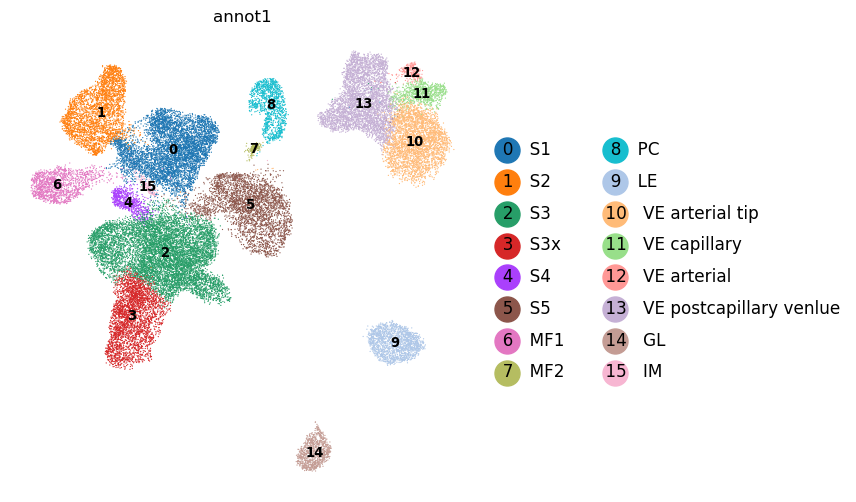

In [19]:
sk.plot_embedding(rna_ad, basis='umap_bk', groupby='annot1', figsize=(6, 6), frameon=False);

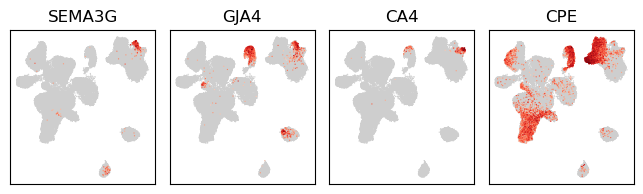

In [20]:
sk.plot_genes(rna_ad, basis='umap_bk', genes=['SEMA3G', 'GJA4', 'CA4', 'SELE', 'CPE']);

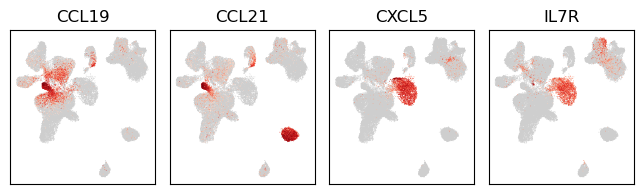

In [21]:
sk.plot_genes(rna_ad, basis='umap_bk', genes=['CCL19', 'CCL21', 'CXCL5', 'IL7R'], size=1);

SEMA3G -> GJA4 -> CA4 -> SELE -> CPE

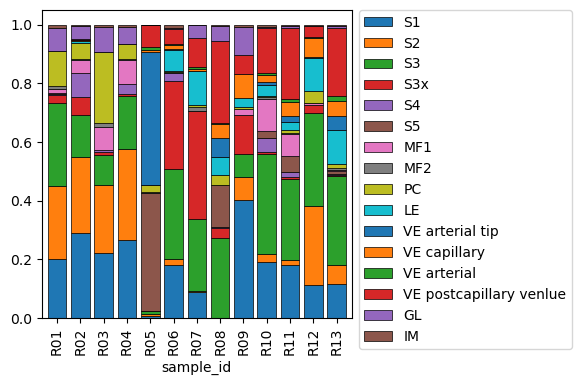

In [45]:
sk.set_figsize((4, 4))
ax = sk.cross_table(rna_ad, 'sample_id', 'annot1', normalise='x').plot.bar(stacked=True, width=0.8, edgecolor='k', linewidth=0.5);
ax.legend(loc='center left', bbox_to_anchor=(1, 0.45));
#ax.set_ylim(102, -2);
#ax.set_yticklabels([102, 100, 80, 60, 40, 20, 0]);

In [47]:
rna_ad.obs['site_state'] = rna_ad.obs.site_taken_fine.astype(str) + ', ' + rna_ad.obs.state.astype(str)
rna_ad.obs['site_state'] = rna_ad.obs['site_state'].astype('category')

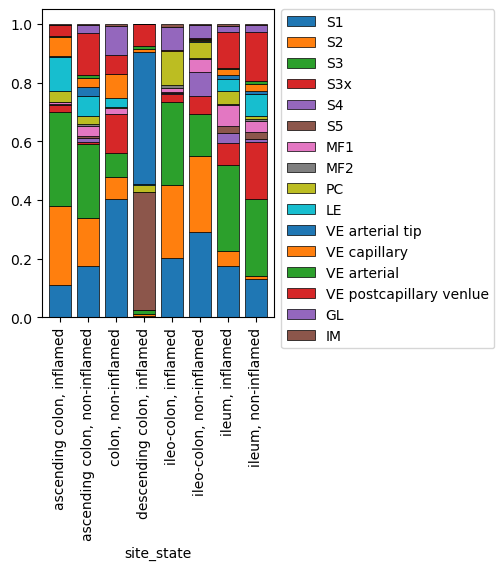

In [48]:
sk.set_figsize((3, 4))
ax = sk.cross_table(rna_ad, 'site_state', 'annot1', normalise='x').plot.bar(stacked=True, width=0.8, edgecolor='k', linewidth=0.5);
ax.legend(loc='center left', bbox_to_anchor=(1, 0.45));
#ax.set_ylim(102, -2);
#ax.set_yticklabels([102, 100, 80, 60, 40, 20, 0]);

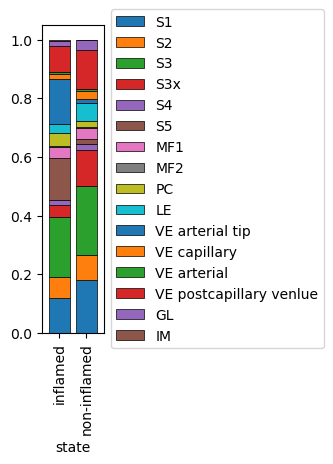

In [50]:
sk.set_figsize((0.8, 4))
ax = sk.cross_table(rna_ad, 'state', 'annot1', normalise='x').plot.bar(stacked=True, width=0.8, edgecolor='k', linewidth=0.5);
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
#ax.set_ylim(102, -2);
#ax.set_yticklabels([102, 100, 80, 60, 40, 20, 0]);

In [51]:
ct_counts = sk.cross_table(rna_ad, 'state', 'annot1').T
ct_props = ct_counts.div(ct_counts.sum(axis=0), axis=1)
ct_l2r = np.log2(ct_props.inflamed / ct_props.loc[:,'non-inflamed'])

In [54]:
coolwarm_cm = cm.ScalarMappable(cnorm(vmin=-5, vmax=5, clip=True), cmap=cm.coolwarm)

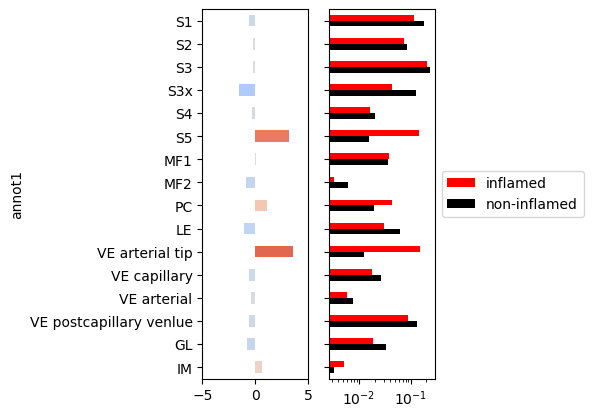

In [55]:
sk.set_figsize((3, 0.3*ct_props.shape[0]))
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, gridspec_kw={'wspace': 0.2})
ct_l2r.plot.barh(ax=ax[0], color=coolwarm_cm.to_rgba(ct_l2r.values));
ax[0].set_xlim(-5, 5);
ax[0].set_ylim(ax[0].get_ylim()[::-1]);
ct_props.plot.barh(ax=ax[1], cmap=state_cmap)
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5));
ax[1].set_ylim(ax[1].get_ylim()[::-1]);
ax[1].set_xscale('log');
# ax[1].set_xlim(0, 0.5);

In [56]:
sk.pl.embedding(rna_ad, basis='umap_bk', color=['site_taken_broad', 'Gender', 'age_years'], wspace=0.5, frameon=False);

AttributeError: module 'sctk' has no attribute 'pl'

/home/jovyan/my-conda-envs/ni_env2/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


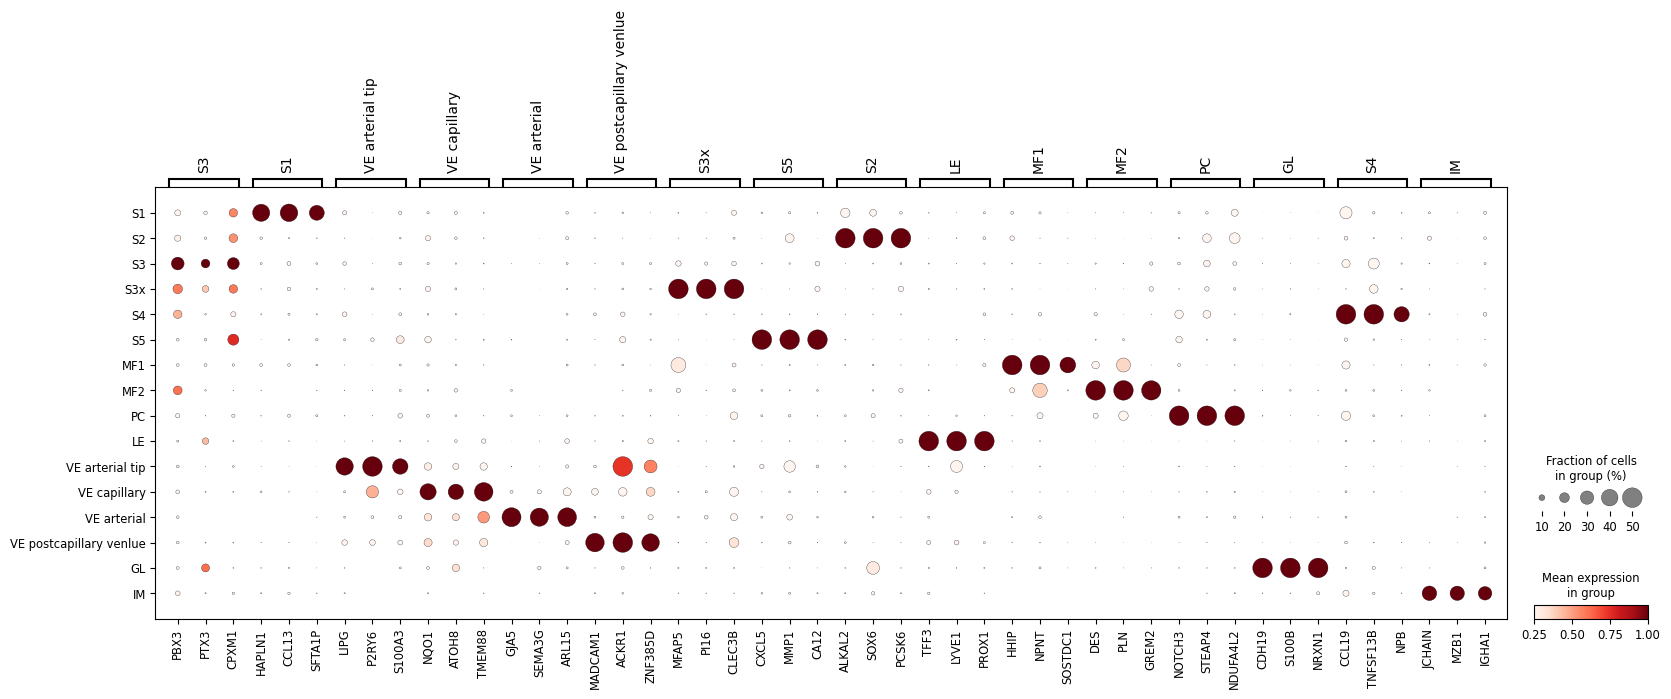

In [57]:
rna_mks = sk.filter_marker_stats(rna_mkst[2], min_frac_diff=0.05, min_mean_diff=0.05, max_next_frac=0.2, max_next_mean=0.9, single=False, how='and')
sk.plot_markers(rna_ad, groupby='annot1', mks=rna_mks, standard_scale='var', color_map='Reds', dot_max=0.5, vmin=0.25, n_genes=3)

In [58]:
fg_pred = sk.LR_predict(rna_ad, '/home/ubuntu/data/scrna/elmentaite20/fetal_gut.lr_norm.pkl', key_added='fetalgut_annot', return_predict=True)
pg_pred = sk.LR_predict(rna_ad, '/home/ubuntu/data/scrna/elmentaite20/ped_gut.lr_norm.pkl', key_added='pedgut_annot', return_predict=True)

ValueError: /home/ubuntu/data/scrna/elmentaite20/fetal_gut.lr_norm.pkl: invalid LR model

In [59]:
import numpy_groupies as npg

In [60]:
import seaborn as sn

In [61]:
sk.plot_embedding(rna_ad, basis='umap_bk', groupby='pedgut_annot', frameon=False, annot='full', min_group_size=10);

KeyError: 'pedgut_annot'

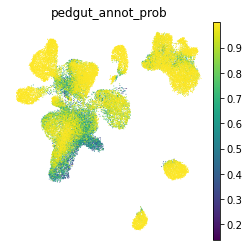

In [90]:
sk.pl.embedding(rna_ad, basis='umap_bk', color=['pedgut_annot_prob'], wspace=0.5, frameon=False);

In [155]:
rna_ad.obs.annot1.cat.codes.shape

(38116,)

In [154]:
pg_pred['prob'].T.shape

(41, 38116)

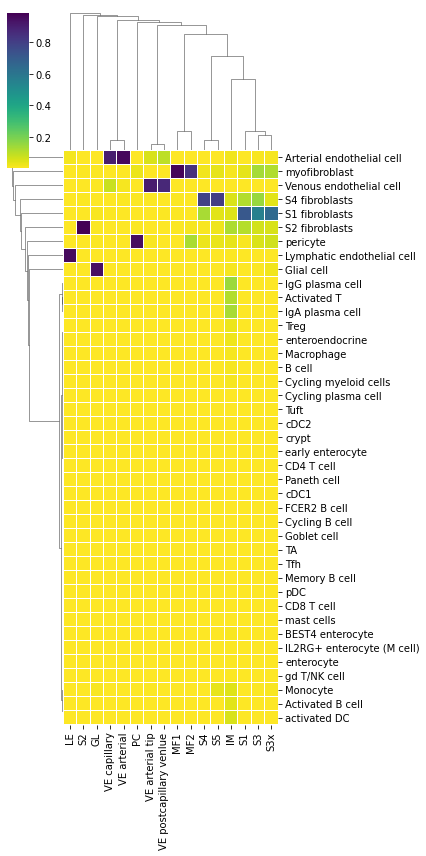

In [118]:
sn.clustermap(pd.DataFrame(
    npg.aggregate(rna_ad.obs.annot1.cat.codes, pg_pred['prob'].values.T, axis=1, func='mean'),
    index=pg_pred['prob'].columns, columns=rna_ad.obs.annot1.cat.categories.to_list()), cmap='viridis_r', linewidths=0.01, figsize=(6, 12))

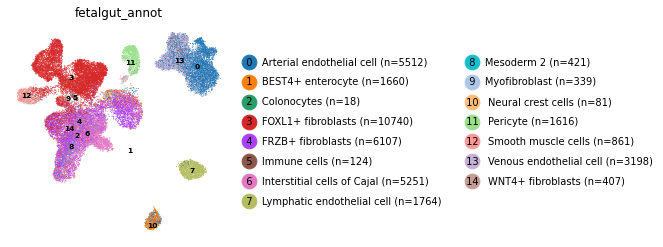

In [89]:
sk.plot_embedding(rna_ad, basis='umap_bk', groupby='fetalgut_annot', frameon=False, annot='full', min_group_size=10);

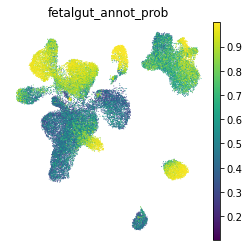

In [91]:
sk.pl.embedding(rna_ad, basis='umap_bk', color=['fetalgut_annot_prob'], wspace=0.5, frameon=False);

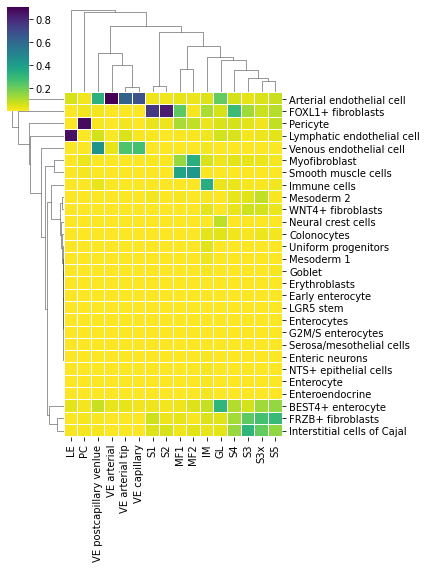

In [115]:
sn.clustermap(pd.DataFrame(
    npg.aggregate(rna_ad.obs.annot1.cat.codes, fg_pred['prob'].values.T, axis=1, func='mean'),
    index=fg_pred['prob'].columns, columns=rna_ad.obs.annot1.cat.categories.to_list()), cmap='viridis_r', linewidths=0.01, figsize=(6, 8))

### DE

In [139]:
rna_ad.obs['patient_id'] = sk.regroup(rna_ad, groupby='sample_id', regroups={
    'P01': ['R01', 'R02'],
    'P02': ['R03', 'R04'],
    'P03': ['R05'],
    'P04': ['R06', 'R07'],
    'P05': ['R08', 'R09'],
    'P06': ['R10', 'R11'],
    'P07': ['R12', 'R13'],
})

In [134]:
rna_adS.obs['patient_id'] = sk.regroup(rna_adS, groupby='sample_id', regroups={
    'P01': ['R01', 'R02'],
    'P02': ['R03', 'R04'],
    'P03': ['R05'],
    'P04': ['R06', 'R07'],
    'P05': ['R08', 'R09'],
    'P06': ['R10', 'R11'],
    'P07': ['R12', 'R13'],
})

In [135]:
rna_adS.obs[[
    'sample_id', 'patient_id', 'GEX_SID', 'ATAC_SID',
    'GEX', 'ATAC', 'Sample', 'DOB', 'Gender', 'date', 'age_years', 'state',
    'disease', 'site_taken_fine', 'site_taken_broad', 'sorted',
    'Nancy_histologic_score', 'slide_look_other', 'whole_tissue_signature']].groupby('sample_id').first().head()

,patient_id,GEX_SID,ATAC_SID,GEX,ATAC,Sample,DOB,Gender,date,age_years,state,disease,site_taken_fine,site_taken_broad,sorted,Nancy_histologic_score,slide_look_other,whole_tissue_signature
sample_id,,,,,,,,,,,,,,,,,,
R01,P01,R01,A01,GX46,NX02,110544,24/10/1951,M,21/6/2018,66,inflamed,CD,ileo-colon,small intestine,CD45-EPCAM-CD31-THY1+PDPN+,4.0,"ulcers, granulation tissue (swapped?)",high
R02,P01,R02,A02,GX34,NX10,110543,24/10/1951,M,21/6/2018,66,non-inflamed,CD,ileo-colon,small intestine,CD45-EPCAM-CD31-THY1+PDPN+,0.0,normal,im
R03,P02,R03,A03,GX58,NX18,110559,6/1/1987,F,5/7/2018,31,inflamed,CD,ileum,small intestine,CD45-EPCAM-CD31-THY1+PDPN+,4.0,"ulcers, granulation tissue",im
R04,P02,R04,A04,GX70,NX26,110560,6/1/1987,F,5/7/2018,31,non-inflamed,CD,ascending colon,large intestine,CD45-EPCAM-CD31-THY1+PDPN+,0.0,normal,im
R05,P03,R05,A05,GX42,NX02,110501,3/6/1976,F,17/5/2018,41,inflamed,CD,descending colon,large intestine,CD45-EPCAM-CD31+THY1+PDPN+,NaN,"502 has ulcers, massive",high


In [141]:
rna_ads = sk.split_by_group(rna_ad, groupby='annot1')

In [204]:
for ct, ct_rna_ad in rna_ads.items():
    print(ct)
    sk._utils.run_diffQuant(
        ct_rna_ad, groupby='sample_id', condition='state', ctrl='non-inflamed', trmt='inflamed',
        groups=['R01', 'R02', 'R03', 'R04', 'R06', 'R07', 'R08', 'R09', 'R10', 'R11', 'R12', 'R13'],
        outprfx=f'{ct.replace(" ", "_")}_RNA_DE_gene_by_state', cofactor=['patient_id'], debug=False
    )

GL
IM
LE
MF1
MF2
PC
S1
S2
S3
S3x
S4
S5
VE arterial
VE arterial tip
VE capillary
VE postcapillary venlue


## ATAC

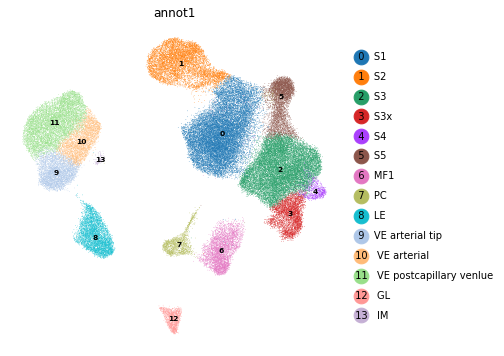

In [122]:
sk.plot_embedding(atacP_ad, basis='umap_bk', groupby='annot1', figsize=(6, 6), frameon=False);

In [136]:
sk.plot_genes(atacG_ad, basis='umap_bk', genes=['SEMA3G', 'GJA4', 'CA4', 'SELE', 'CPE', 'ACKR4']);

<Figure size 144x144 with 0 Axes>

In [147]:
gene_names = pd.read_csv('../20201116_scATAC_batch1_2/gsm_names.txt', names=['gene']).gene

In [149]:
atacG_ad.shape

(78474, 24766)

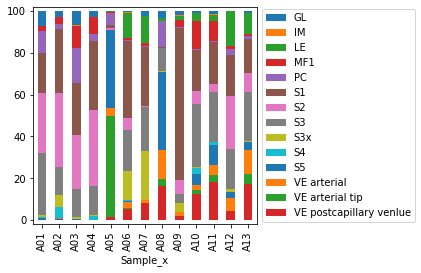

In [48]:
sk.set_figsize((4, 4))
ax = sk.cross_table(atacP_ad, 'Sample_x', 'annot1', normalise='x').plot.bar(stacked=True);
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
ax.set_ylim(102, -2);
ax.set_yticklabels([102, 100, 80, 60, 40, 20, 0]);

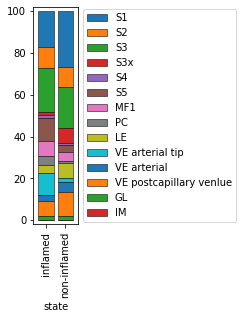

In [70]:
sk.set_figsize((0.8, 4))
ax = sk.cross_table(atacP_ad, 'state', 'annot1', normalise='x').plot.bar(stacked=True, width=0.8, edgecolor='k', linewidth=0.5);
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
ax.set_ylim(102, -2);
ax.set_yticklabels([102, 100, 80, 60, 40, 20, 0]);

In [68]:
ct_counts = sk.cross_table(atacP_ad, 'state', 'annot1').T
ct_props = ct_counts.div(ct_counts.sum(axis=0), axis=1)
ct_l2r = np.log2(ct_props.inflamed / ct_props.loc[:,'non-inflamed'])

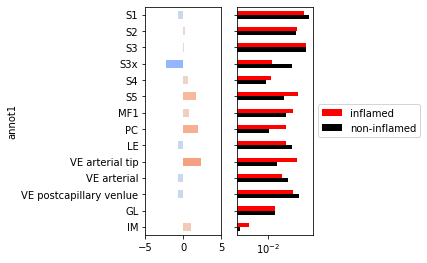

In [69]:
sk.set_figsize((3, 0.3*ct_props.shape[0]))
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, gridspec_kw={'wspace': 0.2})
ct_l2r.plot.barh(ax=ax[0], color=coolwarm_cm.to_rgba(ct_l2r.values));
ax[0].set_xlim(-5, 5);
ax[0].set_ylim(ax[0].get_ylim()[::-1]);
ct_props.plot.barh(ax=ax[1], cmap=state_cmap)
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5));
ax[1].set_ylim(ax[1].get_ylim()[::-1]);
ax[1].set_xscale('log');

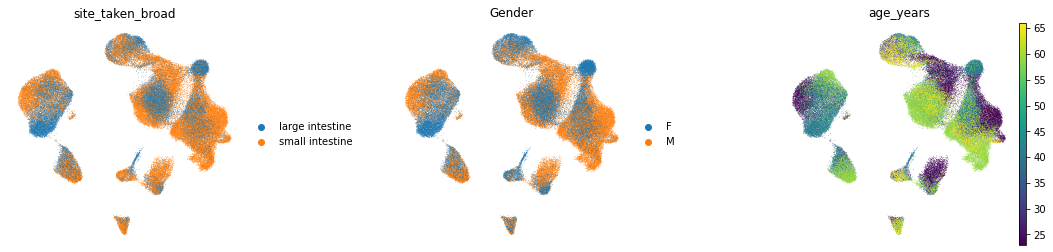

In [26]:
sk.pl.embedding(atacP_ad, basis='umap_bk', color=['site_taken_broad', 'Gender', 'age_years'], wspace=0.5, frameon=False);

In [71]:
!ls *.pkl

ibd_gut.scrna.lognorm.pkl  scRNA_batch1_2.annot1_mkst.pkl  smillie19_lr.pkl


In [72]:
atacP_mkst = joblib.load('../20201116_scATAC_batch1_2/scATAC_PeakMatrix.annot1_mkst.pkl')

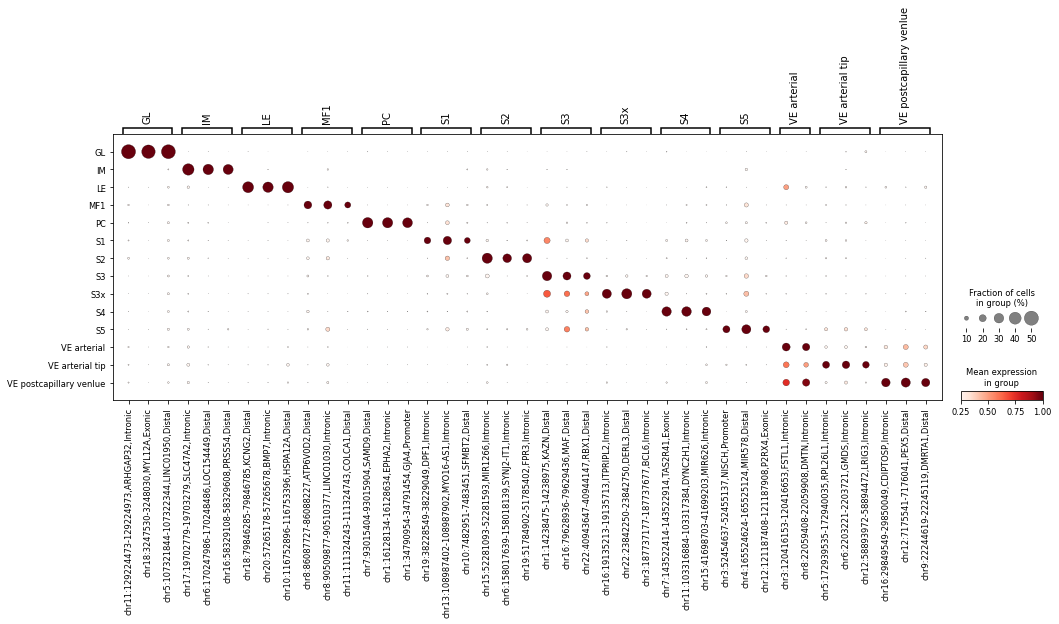

In [13]:
atacP_mks = sk.filter_marker_stats(atacP_mkst[2], min_frac_diff=0.05, min_mean_diff=0.05, max_next_frac=0.2, max_next_mean=0.9, single=False, how='and')
sk.plot_markers(atacP_ad, groupby='annot1', mks=atacP_mks, standard_scale='var', color_map='Reds', dot_max=0.5, vmin=0.25, n_genes=3)

In [77]:
atacP_mkst[2].top_frac_group.cat.reorder_categories(atacP_ad.obs.annot1.cat.categories.to_list(), inplace=True)

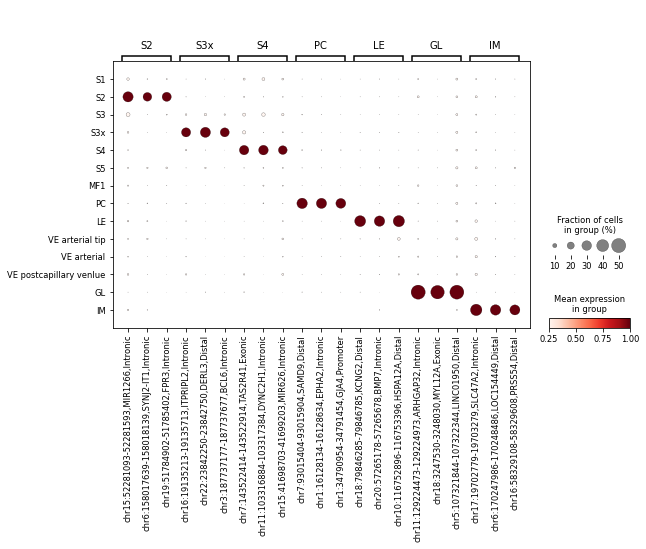

In [81]:
atacP_mks = sk.filter_marker_stats(
    atacP_mkst[2], min_frac_diff=0.2, min_mean_diff=0.5, max_next_frac=0.8, max_next_mean=0.3, single=False, how='or')
sk.plot_markers(atacP_ad, groupby='annot1', mks=atacP_mks, standard_scale='var', color_map='Reds', dot_max=0.5, vmin=0.25, n_genes=3)

### DE

In [3]:
atacG_ad.obs['patient_id'] = sk.regroup(atacG_ad, groupby='Sample_x', regroups={
    'P01': ['A01', 'A02'],
    'P02': ['A03', 'A04'],
    'P03': ['A05'],
    'P04': ['A06', 'A07'],
    'P05': ['A08', 'A09'],
    'P06': ['A10', 'A11'],
    'P07': ['A12', 'A13'],
})

In [4]:
atacG_ad.var_names = atacG_ad.var.name.values

In [5]:
tmp_ad = atacG_ad.raw.to_adata()
tmp_ad.var_names = tmp_ad.var.name.values
atacG_ad.raw = tmp_ad
del tmp_ad

In [6]:
atacG_ads = sk.split_by_group(atacG_ad, groupby='predictedGroup_Co_hm')

In [7]:
for ct, ct_atacG_ad in atacG_ads.items():
    print(ct)
    sk._utils.run_diffQuant(
        ct_atacG_ad, groupby='Sample_x', condition='state', ctrl='non-inflamed', trmt='inflamed',
        groups=['A01', 'A02', 'A03', 'A04', 'A06', 'A07', 'A08', 'A09', 'A10', 'A11', 'A12', 'A13'],
        recover_counts=False, debug=False,
        outprfx=f'{ct.replace(" ", "_")}_ATAC_DE_gene_by_state', cofactor=['patient_id']
    )

GL
IM
LE
MF1
MF2
PC
S1
S2
S3
S3x
S4
S5
VE arterial
VE arterial tip
VE capillary
VE postcapillary venlue


In [9]:
atacP_ad.obs['patient_id'] = sk.regroup(atacP_ad, groupby='Sample_x', regroups={
    'P01': ['A01', 'A02'],
    'P02': ['A03', 'A04'],
    'P03': ['A05'],
    'P04': ['A06', 'A07'],
    'P05': ['A08', 'A09'],
    'P06': ['A10', 'A11'],
    'P07': ['A12', 'A13'],
})

In [10]:
atacP_ads = sk.split_by_group(atacP_ad, groupby='annot1')

In [11]:
for ct, ct_atacP_ad in atacP_ads.items():
    print(ct)
    sk._utils.run_diffQuant(
        ct_atacP_ad, groupby='Sample_x', condition='state', ctrl='non-inflamed', trmt='inflamed',
        groups=['A01', 'A02', 'A03', 'A04', 'A06', 'A07', 'A08', 'A09', 'A10', 'A11', 'A12', 'A13'],
        recover_counts=False, debug=False,
        outprfx=f'{ct.replace(" ", "_")}_ATAC_DE_peak_by_state', cofactor=['patient_id']
    )

GL
inflamed-vs-non-inflamed
out of 350631 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]
Warning message:
In DESeqDataSet(se, design = design, ignoreRank) :
  some variables in design formula are characters, converting to factors
estimating size factors
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe c